# Selección de variables y regularización
_Santander Meteorology Group (18-01-2022)_

 * [Introducción](#Introducción)
 * [Base de datos de ejemplo: Breast cancer](#Base-de-datos:-Breast-cancer)
 * [Modelo lineal completo](#Modelo-lineal-completo)
 * [Selección de variables](#Selección-de-variables)
 * [Regularización](#Regularización)

## Introducción
El objetivo principal de un modelo entrenado es que tenga la capacidad de generalizar, es decir, la capacidad de predecir bien nuevos datos que no formen parte de la muestra de entrenamiento (por ejemplo, una muestra de datos de *test*). La relación entre el número de observaciones y el número de variables independientes es clave en la capacidad de generalización de los modelos.

Para evitar el sobreajuste en situaciones donde el número de observaciones es del orden, o menor, que el de grados de libertad del sistema y/o donde hay colinealidad, se utilizan (entre otras) técnicas como la selección de variables y la regularización. La primera permite seleccionar de forma objetiva un subconjunto de variables predictoras, mientras que la segunda actúa sobre los parámetros del modelo, impidiendo que tomen valores elevados que harían al modelo muy sensible a diferentes muestras de entrenamiento.

## Base de datos: Breast cancer

En este ejemplo trabajaremos con la base de datos [_Breast cancer_ (Diagnostic)](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), incluida en Kaggle. El objetivo de este conjunto de datos es clasificar a las pacientes en base a si el cáncer de mama que tienen es benigno (`B`) o maligno (`M`). Pamra ello se utilizan 31 predictores relacionados con las propiedades de las células cancerígenas, que en comparación con el número de observaciones (569) es bajo.

Leemos la base de datos:

In [39]:
datos <- read.csv("breastcancer.csv")
str(datos)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se            

Y la preparamos la base de datos de la siguiente manera:

In [40]:
# Eliminar no predictores (id y última columna vacía)
df <- datos[, -c(1, ncol(datos)-1, ncol(datos))]
# Convertir el factor diagnosis (B y M) a los valores numéricos 0 y 1, respectivamente.
df$diagnosis <- as.numeric(df$diagnosis)-1
# Normalizar los datos (predictores o features) para evitar problemas de diferente variabilidad
df[-1] <- apply(df[-1], MARGIN = 2, scale)
rm(datos)
dim(df)
head(df)

[1] 569  30

diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,...,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst
1,1.0960995,-2.0715123,1.2688173,0.9835095,1.5670875,3.2806281,2.65054179,2.5302489,2.215565542,...,0.90628565,1.8850310,-1.35809849,2.3015755,1.9994782,1.3065367,2.6143647,2.1076718,2.2940576,2.7482041
1,1.8282120,-0.3533215,1.6844726,1.9070303,-0.8262354,-0.4866435,-0.02382489,0.5476623,0.001391139,...,-0.09935632,1.8043398,-0.36887865,1.5337764,1.8888270,-0.3752817,-0.4300658,-0.1466200,1.0861286,-0.2436753
1,1.5784992,0.4557859,1.5651260,1.5575132,0.9413821,1.0519999,1.36227979,2.0354398,0.938858720,...,0.29330133,1.5105411,-0.02395331,1.3462906,1.4550043,0.5269438,1.0819801,0.8542223,1.9532817,1.1512420
1,-0.7682333,0.2535091,-0.5921661,-0.7637917,3.2806668,3.3999174,1.91421287,1.4504311,2.864862154,...,2.04571087,-0.2812170,0.13386631,-0.2497196,-0.5495377,3.3912907,3.8899747,1.9878392,2.1738732,6.0407261
1,1.7487579,-1.1508038,1.7750113,1.8246238,0.2801253,0.5388663,1.36980615,1.4272370,-0.009552062,...,0.49888916,1.2974336,-1.46548091,1.3373627,1.2196511,0.2203623,-0.3131190,0.6126397,0.7286181,-0.8675896
1,-0.4759559,-0.8346009,-0.3868077,-0.5052059,2.2354545,1.2432416,0.86554001,0.8239307,1.004517928,...,0.48641784,-0.1653528,-0.31356043,-0.1149083,-0.2441054,2.0467119,1.7201029,1.2621327,0.9050914,1.7525273


Podemos comprobar que hay colinealidades en los datos

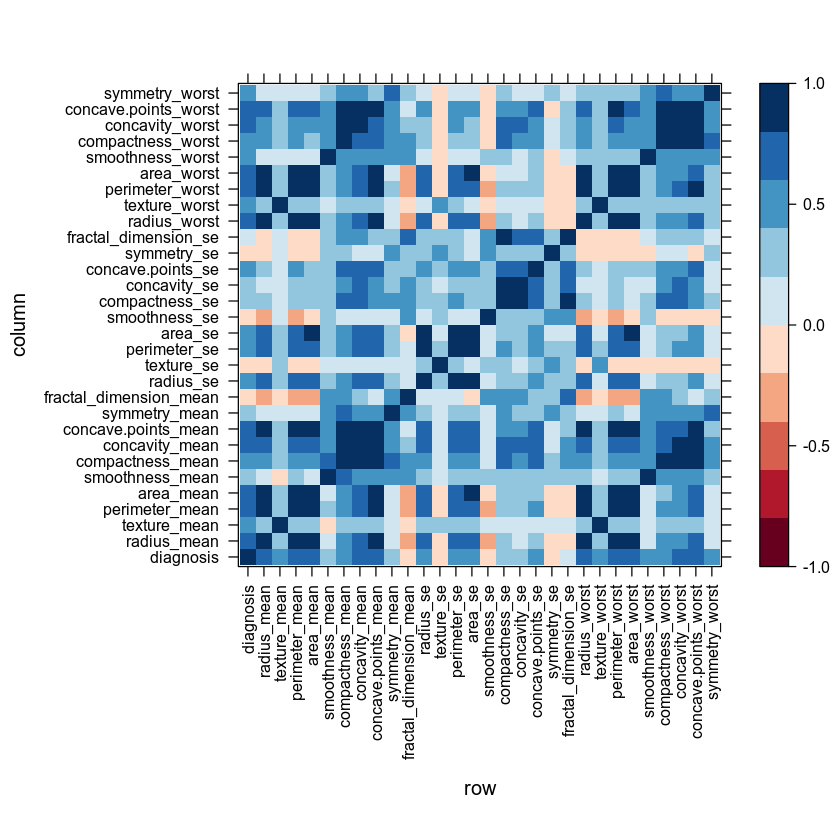

In [41]:
library(RColorBrewer) # brewer.pal
library(lattice) # levelplot
colores <- brewer.pal(10,"RdBu")
levelplot(cor(df), # ó simplemente image(cor(df))
  at = seq(-1, 1, 0.2), col.regions = colores,
  scale = list(x = list(rot = 90)) # gira 90º las etiquetas del eje X
)

## Modelo lineal completo

Construyamos el modelo lineal mediante la función `glm`. Como la variable respuesta sigue una distribución de Bernouilli lo más apropiado es realizar una regresión logística, es decir: familia binomial, link _logit_ (por defecto para esta familia).

In [121]:
model <- glm(diagnosis ~ ., data = df, family = "binomial") # ídem family =  binomial(link = "logit"), ver ?family
pred  <- predict(model, type = "response") # type = "response" devuelve las probabilidades predichas entre 0 y 1.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Vemos que surgen algunas alertas sobre la convergencia del algoritmo (probablemente debidas a las colinealidades en nuestros predictores) y de sobreajuste (predicciones deterministas de 0 o 1).

Para comprobar la capacidad predictiva de nuestro modelo en la clasificación del cáncer de mama, utilizaremos el índice Área bajo la curva ROC (AUC, por sus siglas en inglés) disponible en las librerías `verification` y `pROC`.

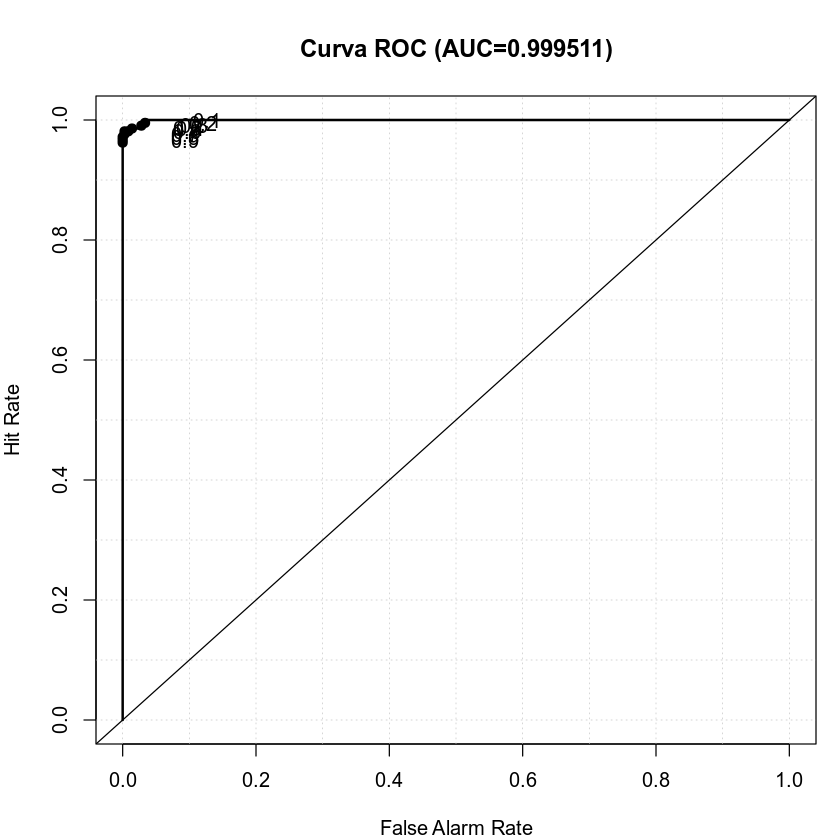

In [126]:
# Paquete verification para ROC y roc area
# options(download.file.method="wget") # esta línea es necesaria en el HUB para instalar paquetes a través de una url
 #install.packages("verification")
library(verification, quietly = TRUE) # roc.area
auc <- roc.area(obs = df$diagnosis,pred)$A
roc.plot(df$diagnosis, pred, main=sprintf("Curva ROC (AUC=%g)", auc))

In [124]:
# Análogamente con el paquete pROC
install.packages("pROC")
library(pROC)
roc_obj <- roc(df$diagnosis, pred)
auc(roc_obj)
plot.roc(roc_obj,print.auc=T, print.thres = "best")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Setting levels: control = 0, case = 1

Setting direction: controls < cases



ERROR: Error in rank(prob): el argumento "prob" está ausente, sin valor por omisión


También podríamos comprobar los resultados del modelo en una tabla de contingencia (_confusion matrix_), pero en este caso necesitamos convertir las predicciones probabilistas del modelo en valores cualitativos (factores) deterministas. Para ello usamos un umbral de decisión. En este ejemplo usamos 0.5 como umbral; prueba a modificarlo para ver el efecto sobre los aciertos del modelo (esto es lo que hace la curva ROC).

In [125]:
#install.packages("caret")
library(caret, quietly = TRUE) # confusionMatrix
confusionMatrix(as.factor(as.numeric(pred>0.5)), as.factor(df$diagnosis), positive="1")


# Alternativa sin usar caret
outbin <- as.double(pred > 0.5)
table(df$diagnosis, outbin, dnn=c("Ref.","Pred."))
# Accuracy
100*sum(diag(table(df$diagnosis, outbin))) / length(outbin)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 355   4
         1   2 208
                                          
               Accuracy : 0.9895          
                 95% CI : (0.9772, 0.9961)
    No Information Rate : 0.6274          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9774          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9811          
            Specificity : 0.9944          
         Pos Pred Value : 0.9905          
         Neg Pred Value : 0.9889          
             Prevalence : 0.3726          
         Detection Rate : 0.3656          
   Detection Prevalence : 0.3691          
      Balanced Accuracy : 0.9878          
                                          
       'Positive' Class : 1               
                              

    Pred.
Ref.   0   1
   0 355   2
   1   4 208

[1] 98.94552

**TAREA 1:** Estudiar la capacidad de generalización del modelo completo mediante una validacion cruzada de tipo *hold out*, es decir, utilizando una parte de los datos para entrenar el modelo y reservando otra para probarlo.

Separamos en dos conjuntos disjutos: uno de train (70% del total) y uno de test (30% del total):

In [97]:
idx.train <- sample(1:nrow(df), ceiling(0.7 * nrow(df)))
idx.test <- setdiff(1:nrow(df), idx.train)

In [99]:
model.cv <- glm(diagnosis ~ ., data = df, subset = idx.train, family = "binomial") 
pred.cv  <- predict(model.cv, df[idx.test, -1], type = "response") # type = "response" devuelve las probabilidades predichas entre 0 y 1.

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [100]:
pred.cv

2            3            5            9           13           18 
1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 
          20           23           27           30           33           34 
2.220446e-16 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 
          47           53           58           62           63           64 
2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 
          65           69           79           80           82           83 
1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 1.000000e+00 
          84           88           91           92           94           95 
1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 
          99          102          104          106          110          115 
2.220446e-16 2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 
         116          118          121          123          125          128 
2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 
         130          131          135          136          137          142 
1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 1.000000e+00 
         161          163          164          165          168          171 
2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 1.000000e+00 2.220446e-16 
         174          176          181          182          184          187 
2.220446e-16 2.220446e-16 1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 
         190          202          208          210          211          213 
2.220446e-16 1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 1.000000e+00 
         216          221          224          228          229          233 
9.999912e-01 2.220446e-16 1.000000e+00 2.220446e-16 4.567787e-01 2.220446e-16 
         236          238          241          253          256          257 
2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 1.000000e+00 1.000000e+00 
         258          262          265          270          273          276 
1.000000e+00 1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 1.000000e+00 
         277          278          279          286          289          290 
2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 
         292          301          302          304          305          308 
2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         316          317          319          323          324          328 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 
         330          338          342          348          353          355 
1.000000e+00 1.000000e+00 2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 
         361          367          372          373          382          385 
2.220446e-16 1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 
         388          391          392          393          398          402 
2.220446e-16 2.220446e-16 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 
         405          406          408          413          426          432 
2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         440          442          445          446          447          450 
2.220446e-16 1.000000e+00 1.000000e+00 3.786965e-07 1.000000e+00 1.000000e+00 
         452          453          454          457          459          463 
1.000000e+00 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 2.220446e-16 
         470          477          485          488          497          498 
2.220446e-16 6.509280e-12 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 
         499          500          508          515          520          525 
1.000000e+00 1.000000e+00 2.220446e-16 1.000000e+00 2.220446e-16 2.220446e-16 
         526          530          531          534          

Empleamos ROC como métrica de validación:

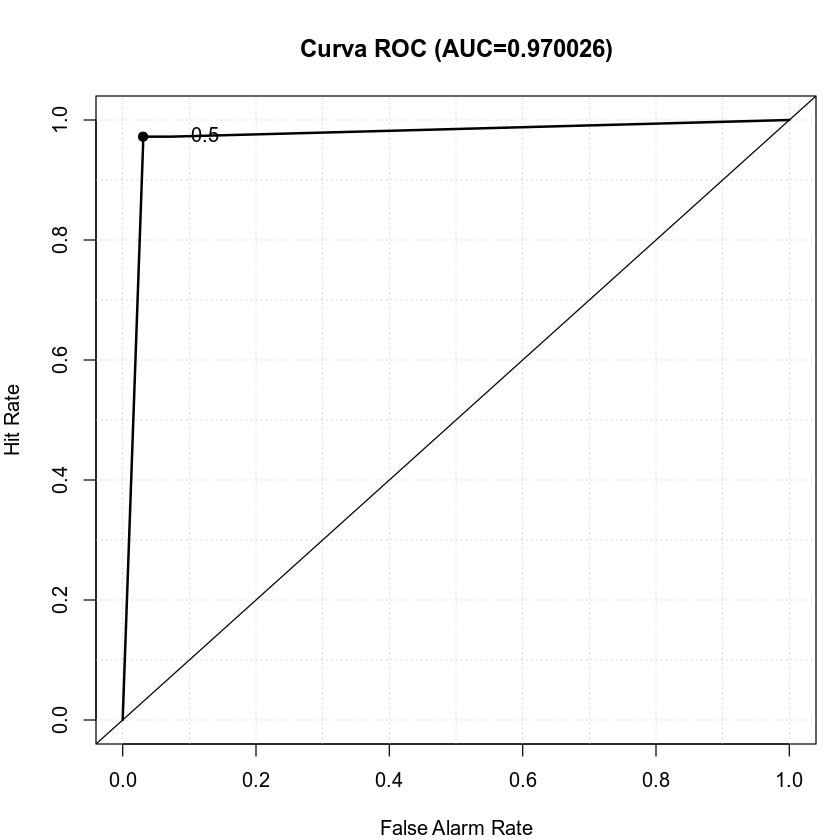

In [132]:
auc.cv <- roc.area(obs = df$diagnosis[idx.test], pred.cv)$A
roc.plot(df$diagnosis[idx.test], pred.cv, main=sprintf("Curva ROC (AUC=%g)", auc.cv))

Empleamos el accuracy como métrica de validación. Para ello, necesitamos pasar nuestra salida a binaria. EMpleamos un umbral de probabilidad de 0.5:

In [133]:
confusionMatrix(as.factor(as.numeric(pred.cv > 0.5)), as.factor(df$diagnosis[idx.test]), positive="1")

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 95  2
         1  3 70
                                          
               Accuracy : 0.9706          
                 95% CI : (0.9327, 0.9904)
    No Information Rate : 0.5765          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9399          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9722          
            Specificity : 0.9694          
         Pos Pred Value : 0.9589          
         Neg Pred Value : 0.9794          
             Prevalence : 0.4235          
         Detection Rate : 0.4118          
   Detection Prevalence : 0.4294          
      Balanced Accuracy : 0.9708          
                                          
       'Positive' Class : 1               
                                    

In [139]:
# Alternativa sin usar caret
outbin.cv <- as.double(pred.cv > 0.5)
table(df$diagnosis[idx.test], outbin.cv, dnn=c("Ref.","Pred."))
# Accuracy
cat("Accuracy: ")
cat(100*sum(diag(table(df$diagnosis[idx.test], outbin.cv))) / length(outbin.cv))

    Pred.
Ref.  0  1
   0 95  3
   1  2 70

Accuracy: 97.05882

## Selección de variables



### Selección del mejor subconjunto

La función `regsubsets` (`?regsubsets`) de la librería `leaps` nos permite realizar la selección del mejor subconjunto con un número dado de predictores. La sintaxis es similar a la usada para el modelo lineal (`lm`) y, del mismo modo, el comando `summary` nos permite explorar los resultados. Utilizamos el argumento `nvmax` para forzar la utilización de todas las variables (30), ya que por defecto la función regsubsets solo utiliza las 8 primeras.

In [8]:
library(leaps)
regfit.full <- regsubsets(diagnosis ~., df, nvmax = 30) # por defecto method="exhaustive"
# nvmax numero maximos de variables. Por defecto 8

La función `summary` devuelve medidas del ajuste que se pueden usar para seleccionar el mejor modelo.

In [9]:
full.summary <- summary(regfit.full)
names(full.summary)
# cuando el bic e smínimo, entonces el número de varianles es óptimo

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

En particular, si revisamos los valores del ajuste, en este caso rsq ($R^2$, el coeficiente de determinación), se observa que el estadístico va mejorando a medida que aumentamos el número de variables en el modelo. No puede ser de otra manera, ya que este estadístico está relacionado con la varianza explicada por nuestro modelo, que aumenta monótonamente al incluir variables adicionales. Sin embargo, si nos fijamos en el estadístico BIC (*Bayesian information criterion*), que penaliza la complejidad del modelo (el número de variables predictoras), se observa que los valores óptimos se encuentran considerando 11 variables.

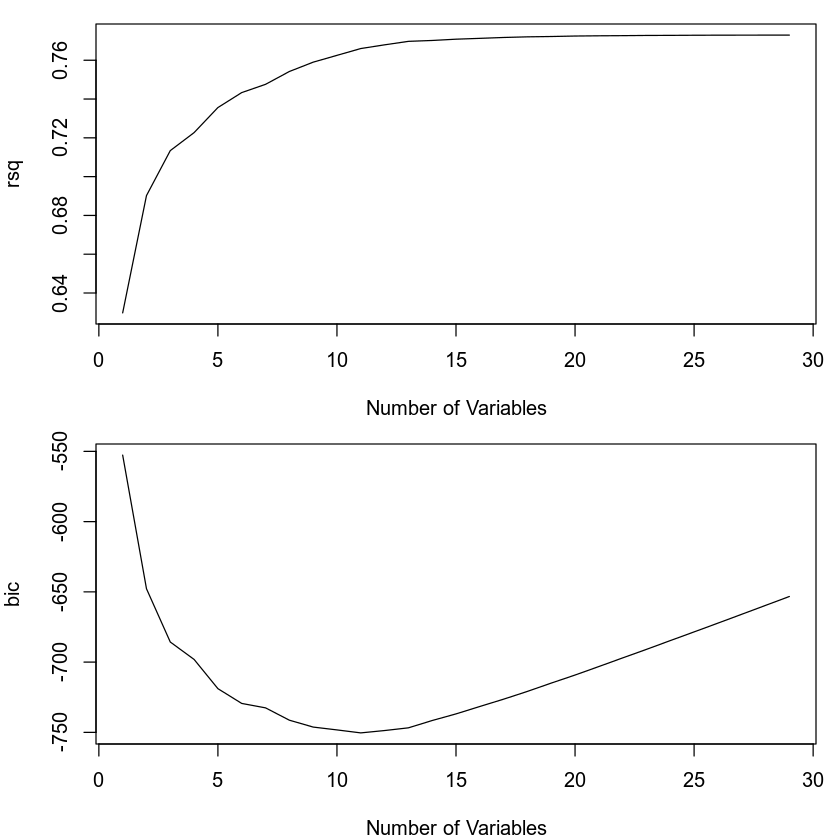

In [26]:
scores <- c("rsq", "bic")
par(mfrow=c(length(scores),1), mar=c(4,4,1,1))
for (score in scores){
  plot(full.summary[[score]], xlab="Number of Variables", ylab=score, type="l")
}

In [11]:
which.min(full.summary$bic)

[1] 11

La propia función `regsubsets` incorpora un método para dibujar los resultados clasificados según los diferentes estadísticos (`? plot.regsubsets`)

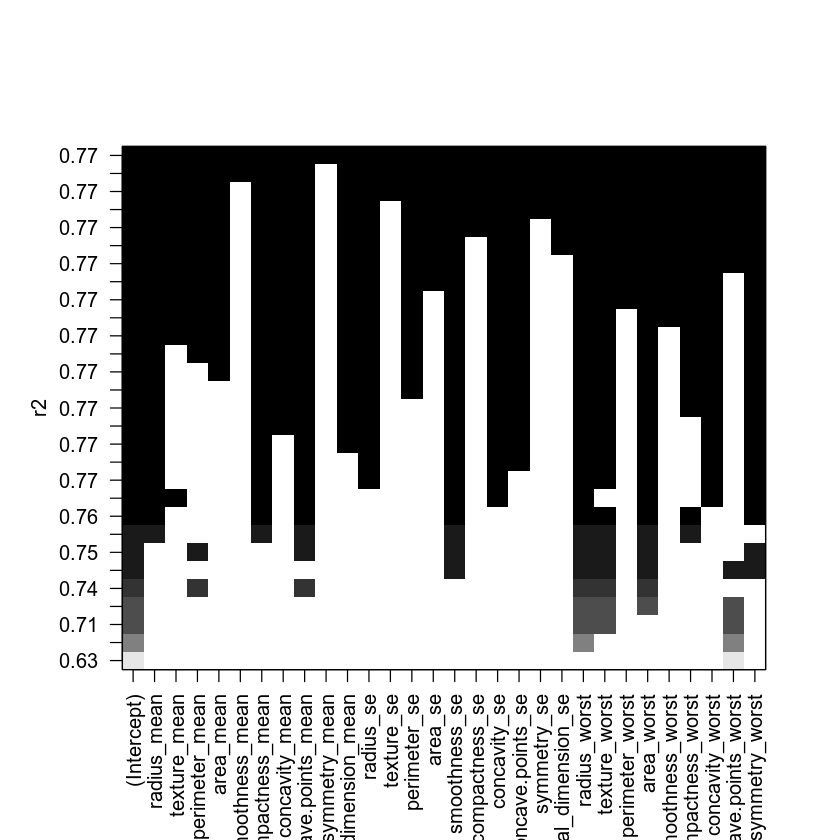

In [12]:
plot(regfit.full, scale ="r2")
#plot(regfit.full, scale ="bic")

Cada fila de este gráfico representa el mejor modelo ajustado para un número dado de variables. Cada cuadrado de color representa que la variable entra en ese modelo, mientras que la intensidad del color se asocia con la escala del eje Y.

Una vez localizado el modelo óptimo (en nuestro caso, el de 11 variables), si queremos conocer los coeficientes del modelo, podemos usar la función `coef` con un segundo argumento:

In [27]:
coef(regfit.full, 11)

(Intercept)         radius_mean    compactness_mean concave.points_mean 
         0.37258348         -0.17840169         -0.12933228          0.19664469 
          radius_se       smoothness_se        concavity_se        radius_worst 
         0.05803878          0.06566972         -0.06679611          0.87351926 
      texture_worst          area_worst     concavity_worst      symmetry_worst 
         0.06189087         -0.56390219          0.15446712          0.04610665

### Selección stepwise
Al no haber especificado método de selección, la búsqueda del mejor modelo de la sección anterior ha sido exhaustiva. Con un leve cambio en los argumentos de la función podemos realizar la selección _stepwise_, ya sea “forward” o “backward”:

In [28]:
regfit.fwd <- regsubsets(diagnosis~., data = df, nvmax = 30 , method ="forward")
fwd.summary <- summary(regfit.fwd)

**TAREA 2:** Estudiar los predictores seleccionados en este caso. ¿cuál es su número óptimo? ¿coinciden con los anteriores?

**TAREA 3:** Comparar la selección realizada por el método _backward_ con los métodos exhaustivo y _forward stepwise_.

### Selección mediante la función step
Otra opción para realizar la selección _stepwise_ es usar la función `step`, que forma parte del paquete básico `stats` de R:

In [29]:
initialModel_0 <- glm(diagnosis ~ 1, data = df, family=binomial(link="logit"))
initialModel_p <- glm(diagnosis ~ ., data = df, family=binomial(link="logit"))

fw <- step(initialModel_0,
  scope = list(lower = formula(initialModel_0), upper = formula(initialModel_p)),
  direction = "forward"
)
summary(fw)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Start:  AIC=753.44
diagnosis ~ 1



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ perimeter_worst         1   209.48 213.48
+ radius_worst            1   229.11 233.11
+ area_worst              1   230.64 234.64
+ concave.points_worst    1   250.45 254.45
+ concave.points_mean     1   258.92 262.92
+ perimeter_mean          1   304.48 308.48
+ area_mean               1   325.66 329.66
+ radius_mean             1   330.01 334.01
+ area_se                 1   359.50 363.50
+ concavity_mean          1   383.23 387.23
+ concavity_worst         1   437.70 441.70
+ perimeter_se            1   472.83 476.83
+ radius_se               1   480.65 484.65
+ compactness_worst       1   505.55 509.55
+ compactness_mean        1   508.79 512.79
+ texture_worst           1   622.07 626.07
+ symmetry_worst          1   641.42 645.42
+ smoothness_worst        1   641.42 645.42
+ concave.points_se       1   646.01 650.01
+ texture_mean            1   646.52 650.52
+ smoothness_mean         1   673.95 677.95
+ symmetry_mean           1   68

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ smoothness_worst        1   139.18 145.18
+ concave.points_worst    1   149.59 155.59
+ texture_worst           1   159.68 165.68
+ concave.points_mean     1   162.47 168.47
+ smoothness_mean         1   165.18 171.18
+ symmetry_worst          1   167.85 173.85
+ concavity_worst         1   168.55 174.55
+ concavity_mean          1   169.78 175.78
+ radius_mean             1   173.15 179.15
+ compactness_worst       1   175.42 181.42
+ symmetry_mean           1   177.18 183.18
+ fractal_dimension_mean  1   177.62 183.62
+ texture_mean            1   178.63 184.63
+ area_mean               1   180.70 186.70
+ compactness_mean        1   181.84 187.84
+ perimeter_mean          1   183.59 189.59
+ smoothness_se           1   191.06 197.06
+ texture_se              1   195.30 201.30
+ concave.points_se       1   198.67 204.67
+ radius_se               1   199.25 205.25
+ area_se                 1   201.45 207.45
+ symmetry_se             1   20

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                         Df Deviance    AIC
+ texture_worst           1   103.61 111.61
+ texture_mean            1   106.84 114.84
+ texture_se              1   122.51 130.51
+ area_se                 1   123.42 131.42
+ radius_se               1   124.89 132.90
+ perimeter_se            1   130.42 138.42
+ concavity_mean          1   133.31 141.31
+ symmetry_worst          1   134.45 142.45
+ area_worst              1   134.65 142.65
+ symmetry_se             1   135.31 143.31
+ concave.points_mean     1   135.35 143.35
+ concave.points_worst    1   135.57 143.57
+ concavity_worst         1   135.97 143.97
+ symmetry_mean           1   136.21 144.21
+ concave.points_se       1   136.32 144.32
<none>                        139.18 145.18
+ concavity_se            1   137.42 145.42
+ radius_worst            1   137.53 145.53
+ radius_mean             1   137.66 145.66
+ perimeter_mean          1   137.81 145.81
+ smoothness_se           1   138.54 146.54
+ area_mean               1   13

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=111.61
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance     AIC
+ radius_se               1   87.205  97.205
+ area_se                 1   87.437  97.437
+ perimeter_se            1   94.237 104.237
+ concave.points_mean     1   94.884 104.884
+ concave.points_se       1   98.633 108.633
+ symmetry_mean           1   98.669 108.669
+ concavity_mean          1   98.727 108.727
+ symmetry_se             1   98.826 108.826
+ concave.points_worst    1   99.349 109.349
+ symmetry_worst          1  100.170 110.170
+ area_worst              1  100.526 110.526
+ radius_worst            1  101.505 111.505
<none>                       103.612 111.612
+ smoothness_mean         1  101.830 111.830
+ concavity_worst         1  102.514 112.514
+ concavity_se            1  102.560 112.560
+ texture_mean            1  103.218 113.218
+ fractal_dimension_se    1  103.224 113.224
+ texture_se              1  103.237 113.237
+ smoothness_se           1  103.285 113.285
+ compactness_worst       1  103.360 113.360
+ compactn

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=97.2
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ symmetry_worst          1   79.073 91.073
+ concave.points_worst    1   79.196 91.196
+ texture_se              1   82.558 94.558
+ concave.points_mean     1   84.004 96.004
+ concavity_worst         1   84.146 96.146
+ fractal_dimension_se    1   84.287 96.287
+ symmetry_mean           1   84.542 96.542
+ compactness_se          1   84.888 96.888
+ perimeter_se            1   85.151 97.151
+ concavity_mean          1   85.159 97.159
<none>                        87.205 97.205
+ area_worst              1   85.805 97.805
+ smoothness_se           1   85.810 97.810
+ symmetry_se             1   86.025 98.025
+ radius_worst            1   86.030 98.030
+ compactness_mean        1   86.597 98.597
+ fractal_dimension_mean  1   86.729 98.729
+ perimeter_mean          1   86.780 98.780
+ radius_mean             1   86.873 98.873
+ area_mean               1   87.043 99.043
+ texture_mean            1   87.050 99.050
+ smoothness_mean         1   87

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=91.07
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ compactness_se          1   74.511 88.511
+ concave.points_worst    1   74.850 88.850
+ fractal_dimension_se    1   75.551 89.551
+ texture_se              1   75.869 89.869
+ area_worst              1   76.196 90.196
+ compactness_mean        1   76.436 90.436
+ perimeter_se            1   76.737 90.737
+ radius_worst            1   76.821 90.821
+ fractal_dimension_mean  1   76.900 90.900
+ concave.points_mean     1   76.974 90.974
<none>                        79.073 91.073
+ compactness_worst       1   77.638 91.638
+ concavity_worst         1   78.142 92.142
+ symmetry_se             1   78.211 92.211
+ concavity_mean          1   78.438 92.438
+ area_se                 1   78.494 92.494
+ smoothness_mean         1   78.730 92.730
+ smoothness_se           1   78.772 92.772
+ symmetry_mean           1   78.803 92.803
+ area_mean               1   78.899 92.899
+ concavity_se            1   78.973 92.973
+ radius_mean             1   78

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=88.51
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ concavity_mean          1   65.529 81.529
+ concave.points_worst    1   65.593 81.593
+ concave.points_mean     1   67.066 83.066
+ concavity_worst         1   67.234 83.234
+ concave.points_se       1   68.551 84.551
+ concavity_se            1   69.777 85.777
<none>                        74.511 88.511
+ texture_se              1   72.725 88.725
+ perimeter_se            1   73.232 89.232
+ smoothness_se           1   73.614 89.614
+ area_se                 1   73.733 89.733
+ area_worst              1   74.085 90.085
+ radius_worst            1   74.330 90.330
+ symmetry_se             1   74.406 90.406
+ fractal_dimension_mean  1   74.408 90.408
+ texture_mean            1   74.443 90.443
+ compactness_mean        1   74.471 90.471
+ smoothness_mean         1   74.491 90.491
+ perimeter_mean          1   74.498 90.498
+ compactness_worst       1   74.501 90.501
+ fractal_dimension_se    1   74.502 90.502
+ radius_mean             1   74

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=81.53
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ texture_se              1   61.258 79.258
+ concave.points_worst    1   61.850 79.850
+ area_se                 1   63.217 81.217
<none>                        65.529 81.529
+ perimeter_se            1   63.661 81.661
+ area_worst              1   63.951 81.951
+ concave.points_se       1   63.965 81.965
+ radius_worst            1   64.003 82.003
+ compactness_mean        1   64.078 82.078
+ concavity_worst         1   64.328 82.328
+ concave.points_mean     1   64.438 82.438
+ fractal_dimension_mean  1   64.621 82.621
+ smoothness_se           1   64.905 82.905
+ symmetry_mean           1   64.943 82.943
+ fractal_dimension_se    1   65.196 83.196
+ texture_mean            1   65.351 83.351
+ smoothness_mean         1   65.353 83.353
+ symmetry_se             1   65.399 83.399
+ area_mean               1   65.487 83.487
+ concavity_se            1   65.506 83.506
+ radius_mean             1   65.513 83.513
+ perimeter_mean          1   65

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=79.26
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ area_se                 1   58.643 78.643
+ concave.points_worst    1   58.739 78.739
+ area_worst              1   59.167 79.167
<none>                        61.258 79.258
+ radius_worst            1   59.387 79.387
+ perimeter_se            1   59.954 79.954
+ compactness_mean        1   60.049 80.049
+ concave.points_se       1   60.277 80.277
+ concave.points_mean     1   60.323 80.323
+ texture_mean            1   60.489 80.489
+ fractal_dimension_mean  1   60.498 80.498
+ fractal_dimension_se    1   60.500 80.500
+ concavity_worst         1   60.579 80.579
+ smoothness_se           1   60.674 80.674
+ area_mean               1   61.103 81.103
+ radius_mean             1   61.162 81.162
+ compactness_worst       1   61.166 81.166
+ smoothness_mean         1   61.214 81.214
+ symmetry_mean           1   61.254 81.254
+ perimeter_mean          1   61.254 81.254
+ concavity_se            1   61.255 81.255
+ symmetry_se             1   61

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=78.64
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
+ concave.points_worst    1   54.713 76.713
<none>                        58.643 78.643
+ radius_worst            1   57.113 79.113
+ concave.points_se       1   57.485 79.485
+ concavity_worst         1   57.520 79.520
+ perimeter_se            1   57.525 79.525
+ texture_mean            1   57.593 79.593
+ concave.points_mean     1   57.669 79.669
+ area_worst              1   57.684 79.684
+ compactness_mean        1   58.146 80.146
+ symmetry_se             1   58.236 80.236
+ perimeter_mean          1   58.374 80.374
+ fractal_dimension_se    1   58.503 80.503
+ compactness_worst       1   58.538 80.538
+ fractal_dimension_mean  1   58.549 80.549
+ radius_mean             1   58.590 80.590
+ area_mean               1   58.590 80.590
+ smoothness_se           1   58.599 80.599
+ symmetry_mean           1   58.609 80.609
+ concavity_se            1   58.616 80.616
+ smoothness_mean         1   58.640 80.640


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=76.71
diagnosis ~ perimeter_worst + smoothness_worst + texture_worst + 
    radius_se + symmetry_worst + compactness_se + concavity_mean + 
    texture_se + area_se + concave.points_worst



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                         Df Deviance    AIC
<none>                        54.713 76.713
+ radius_worst            1   52.749 76.749
+ area_worst              1   52.828 76.828
+ compactness_mean        1   52.833 76.833
+ perimeter_se            1   53.106 77.106
+ symmetry_mean           1   53.896 77.896
+ texture_mean            1   53.934 77.934
+ symmetry_se             1   54.209 78.209
+ concavity_worst         1   54.216 78.216
+ smoothness_se           1   54.233 78.233
+ perimeter_mean          1   54.240 78.240
+ smoothness_mean         1   54.399 78.399
+ concavity_se            1   54.555 78.555
+ concave.points_se       1   54.569 78.569
+ radius_mean             1   54.594 78.594
+ compactness_worst       1   54.605 78.605
+ fractal_dimension_mean  1   54.611 78.611
+ fractal_dimension_se    1   54.705 78.705
+ concave.points_mean     1   54.709 78.709
+ area_mean               1   54.710 78.710



Call:
glm(formula = diagnosis ~ perimeter_worst + smoothness_worst + 
    texture_worst + radius_se + symmetry_worst + compactness_se + 
    concavity_mean + texture_se + area_se + concave.points_worst, 
    family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3573  -0.0201  -0.0013   0.0000   3.8553  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            1.9809     1.1241   1.762 0.078040 .  
perimeter_worst        2.8181     2.4980   1.128 0.259268    
smoothness_worst       1.2907     0.6868   1.879 0.060215 .  
texture_worst          3.2584     0.8392   3.883 0.000103 ***
radius_se             -2.7572     4.6621  -0.591 0.554248    
symmetry_worst         1.0500     0.4957   2.118 0.034164 *  
compactness_se        -2.3356     0.7304  -3.198 0.001384 ** 
concavity_mean         3.1787     1.2999   2.445 0.014472 *  
texture_se            -1.4802     0.8361  -1.770 0.076657 

El objeto de salida es una lista que contiene múltiples elementos. Entre ellos, ilustramos el resultado anova, que muestra las variables seleccionadas (10 en este caso) en orden de adición y el AIC correspondiente (similar al estadístico BIC) .

In [16]:
fw$anova # a cada variable que añada, disminuye el AIC. Es similar al BIC. Con 10 variables. se queda estable.

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,568,751.44001,753.44001
+ perimeter_worst,-1,541.960065,567,209.47994,213.47994
+ smoothness_worst,-1,70.299730,566,139.18021,145.18021
+ texture_worst,-1,35.568566,565,103.61164,111.61164
+ radius_se,-1,16.406692,564,87.20495,97.20495
+ symmetry_worst,-1,8.132333,563,79.07262,91.07262
+ compactness_se,-1,4.561664,562,74.51095,88.51095
+ concavity_mean,-1,8.982248,561,65.52871,81.52871
+ texture_se,-1,4.270508,560,61.25820,79.25820
+ area_se,-1,2.614785,559,58.64341,78.64341


## Regularización
La regularización consiste en añadir un término a la función objetivo que elimine predictores (regularización L1) o disminuya notablemente su influencia (regularización L2) de tal manera que su capacidad de generalización mejore. El coeficiente estimado estará sesgado, debido al término extra que se ha añadido a la función objetivo, sin embargo su varianza puede disminuir. Este equilibrio entre el sesgo y la varianza es lo que se conoce como _bias-variance tradeoff_. Si el modelo está demasiado sesgado entonces no se capturarán correctamente las relaciones entre predictando y predictor, sin embargo si está muy poco sesgado, la varianza del coeficiente estimado puede ser alta y no generalizar bien.

En R, para regularizar modelos lineales generalizados se utiliza el paquete `glmnet`. El tipo de regularización viene dado por el valor del parámetro `alpha`: para una regularización L1, `alpha = 1`, para una regularización L2, `alpha = 0`. Ambos tipos de regularización penalizan la norma (1 ó 2, en función de si la regularización es L1 o L2) del vector de coeficientes estimados. Una consecuencia de la regularización L1 es que indirectamente selecciona variables al hacer estrictamente 0 algunos coeficientes. El número de coeficientes que se hacen 0 viene determinado por el valor de `lambda`. El valor de lambda óptimo se obtiene mediante validación cruzada a través de la función `cv.glmnet`.

En primer lugar, debemos instalar y cargar las librerías que utilizaremos en los ejemplos:

In [30]:
#install.packages("glmnet")
library(glmnet, quiet = TRUE)

### Regularización L1 (LASSO)
Veamos qué nos puede aportar una regularización L1 en este caso. La función `glmnet`nos permite representar directamente la evolución de los coeficientes del modelo para un rango de valores de $\lambda$.

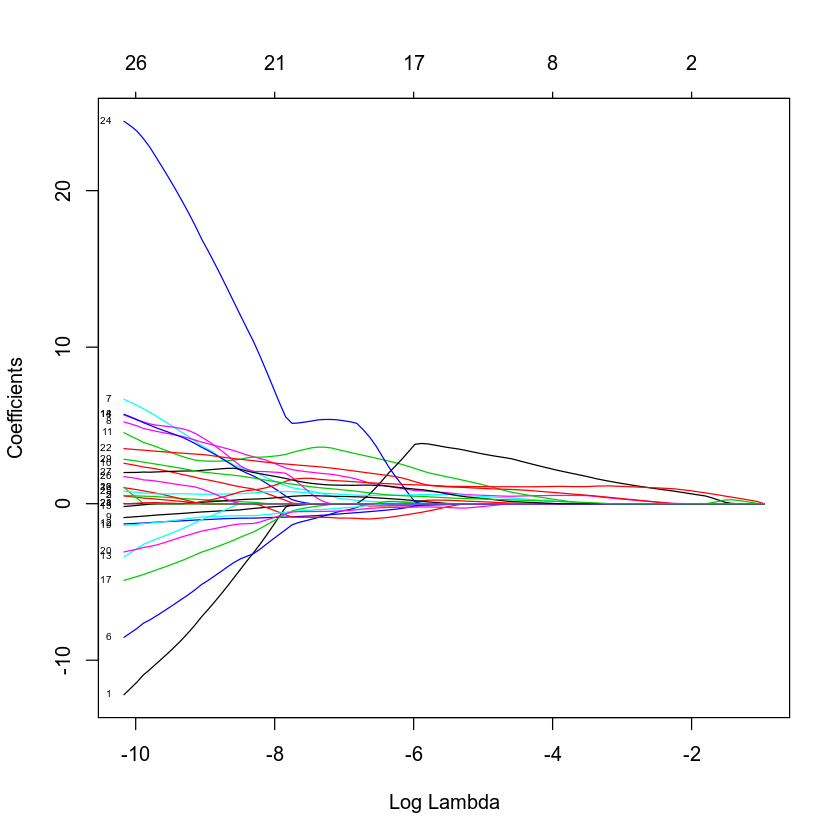

In [31]:
fit <- glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1) 
# valores de lambda por defecto, nlambda=100
plot(fit, label=TRUE, xvar = "lambda") 
# representa los coeficientes frente al log neperiano de lambda

En la parte superior se muestra el número de coeficientes no nulos para cada valor de $\lambda$. Vemos como muchos se hacen 0 al ir aumentando $\lambda$.

Para estimar el valor óptimo de $\lambda$ recurrimos a una validación cruzada mediante la función `cv.glmnet`:

$lambda
 [1] 3.836832e-01 3.495979e-01 3.185406e-01 2.902423e-01 2.644580e-01
 [6] 2.409643e-01 2.195577e-01 2.000528e-01 1.822806e-01 1.660873e-01
[11] 1.513326e-01 1.378886e-01 1.256390e-01 1.144775e-01 1.043077e-01
[16] 9.504127e-02 8.659807e-02 7.890493e-02 7.189523e-02 6.550826e-02
[21] 5.968869e-02 5.438611e-02 4.955460e-02 4.515230e-02 4.114110e-02
[26] 3.748624e-02 3.415606e-02 3.112173e-02 2.835696e-02 2.583781e-02
[31] 2.354245e-02 2.145100e-02 1.954535e-02 1.780900e-02 1.622690e-02
[36] 1.478534e-02 1.347185e-02 1.227505e-02 1.118457e-02 1.019096e-02
[41] 9.285627e-03 8.460717e-03 7.709090e-03 7.024236e-03 6.400222e-03
[46] 5.831644e-03 5.313577e-03 4.841533e-03 4.411425e-03 4.019526e-03
[51] 3.662443e-03 3.337081e-03 3.040624e-03 2.770503e-03 2.524380e-03
[56] 2.300121e-03 2.095784e-03 1.909601e-03 1.739957e-03 1.585384e-03
[61] 1.444543e-03 1.316214e-03 1.199285e-03 1.092744e-03 9.956673e-04
[66] 9.072150e-04 8.266205e-04 7.531858e-04 6.862749e-04 6.253081e-04
[71] 5.69757

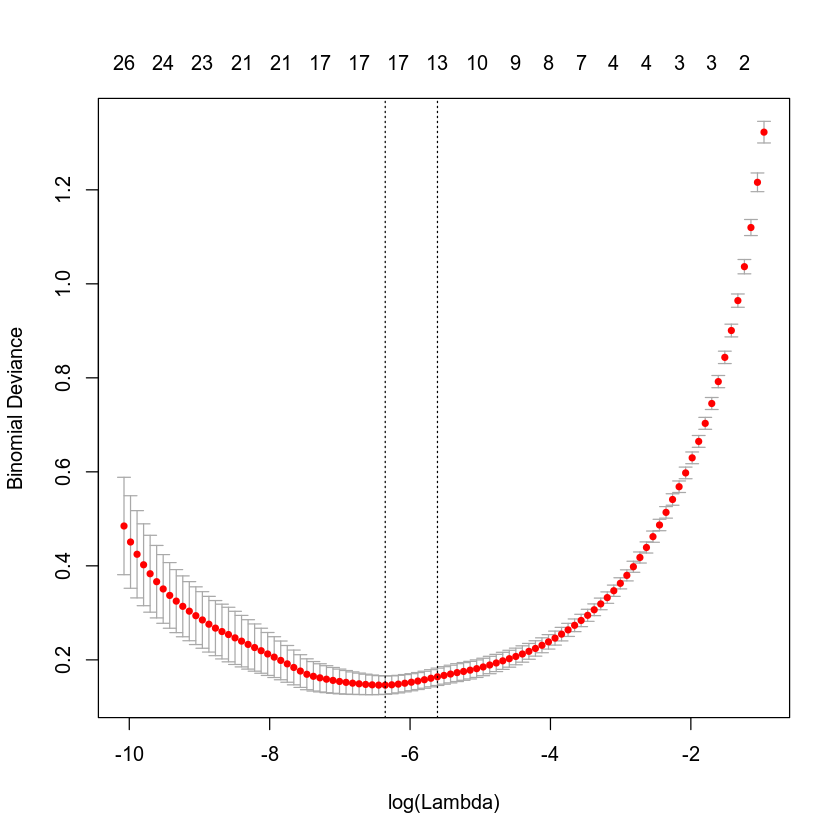

In [32]:
cvfit <- cv.glmnet(as.matrix(df[-1]),df$diagnosis,family = "binomial",alpha = 1)
print(cvfit)
plot(cvfit)

In [34]:
# la de la izquierda es el lambda minimo y la de la derecha con un criterio.

Con este valor de lambda estimado, podemos entrenar el modelo regularizado mediante la función `glmnet`:

In [33]:
model.l1 <- glmnet(as.matrix(df[,-1]), df$diagnosis, family = "binomial", alpha = 1, lambda = cvfit$lambda.1se)
coef(model.l1) # coeficientes del modelo
ind.coef.no.nulos <- which(as.numeric(coef(model.l1)) != 0)
names(df)[ind.coef.no.nulos] # coeficientes no nulos
cat(paste("Number of variables selected:", length(ind.coef.no.nulos)))

30 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)            -0.43027037
radius_mean             .         
texture_mean            0.21869701
perimeter_mean          .         
area_mean               .         
smoothness_mean         .         
compactness_mean        .         
concavity_mean          .         
concave.points_mean     0.73284103
symmetry_mean           .         
fractal_dimension_mean -0.07772632
radius_se               1.80435665
texture_se              .         
perimeter_se            .         
area_se                 .         
smoothness_se           0.05041533
compactness_se         -0.29726794
concavity_se            .         
concave.points_se       .         
symmetry_se             .         
fractal_dimension_se   -0.22934831
radius_worst            3.67085698
texture_worst           1.10683653
perimeter_worst         .         
area_worst              .         
smoothness_worst        0.58743687
compactness_w

[1] "diagnosis"              "texture_mean"           "concave.points_mean"   
 [4] "fractal_dimension_mean" "radius_se"              "smoothness_se"         
 [7] "compactness_se"         "fractal_dimension_se"   "radius_worst"          
[10] "texture_worst"          "smoothness_worst"       "concavity_worst"       
[13] "concave.points_worst"   "symmetry_worst"

Number of variables selected: 14

Vemos que efectivamente la regularización L1 ha hecho 0 muchos coeficientes eliminando grados de libertad del sistema, salvo las características que se observan en la salida anterior.

En realidad, no es necesario invocar de nuevo glmnet. El objeto que devuelve la validación cruzada también contiene los coeficientes correspondientes al $\lambda$ óptimo.

In [35]:
coef(cvfit)

30 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)            -0.43063144
radius_mean             .         
texture_mean            0.22253834
perimeter_mean          .         
area_mean               .         
smoothness_mean         .         
compactness_mean        .         
concavity_mean          .         
concave.points_mean     0.73166442
symmetry_mean           .         
fractal_dimension_mean -0.07866767
radius_se               1.80412973
texture_se              .         
perimeter_se            .         
area_se                 .         
smoothness_se           0.05010458
compactness_se         -0.29820051
concavity_se            .         
concave.points_se       .         
symmetry_se             .         
fractal_dimension_se   -0.22878909
radius_worst            3.67069840
texture_worst           1.10329791
perimeter_worst         .         
area_worst              .         
smoothness_worst        0.58825423
compactness_w

Y podemos solicitar también los del $\lambda$ que minimiza la validación cruzada:

In [36]:
coef(cvfit, s="lambda.min")

30 x 1 sparse Matrix of class "dgCMatrix"
                                1
(Intercept)            -0.0363535
radius_mean             .        
texture_mean            .        
perimeter_mean          .        
area_mean               .        
smoothness_mean         .        
compactness_mean        .        
concavity_mean          0.1100713
concave.points_mean     1.0920061
symmetry_mean           .        
fractal_dimension_mean -0.1389311
radius_se               2.7141862
texture_se             -0.3953014
perimeter_se            .        
area_se                 .        
smoothness_se           0.3217076
compactness_se         -0.8719843
concavity_se            .        
concave.points_se       .        
symmetry_se             .        
fractal_dimension_se   -0.2405319
radius_worst            1.9869199
texture_worst           1.7887423
perimeter_worst         0.1447052
area_worst              2.3130296
smoothness_worst        0.5431543
compactness_worst       .        
concav

Podemos ver el sobreajuste de forma cualitativa con la curva ROC:

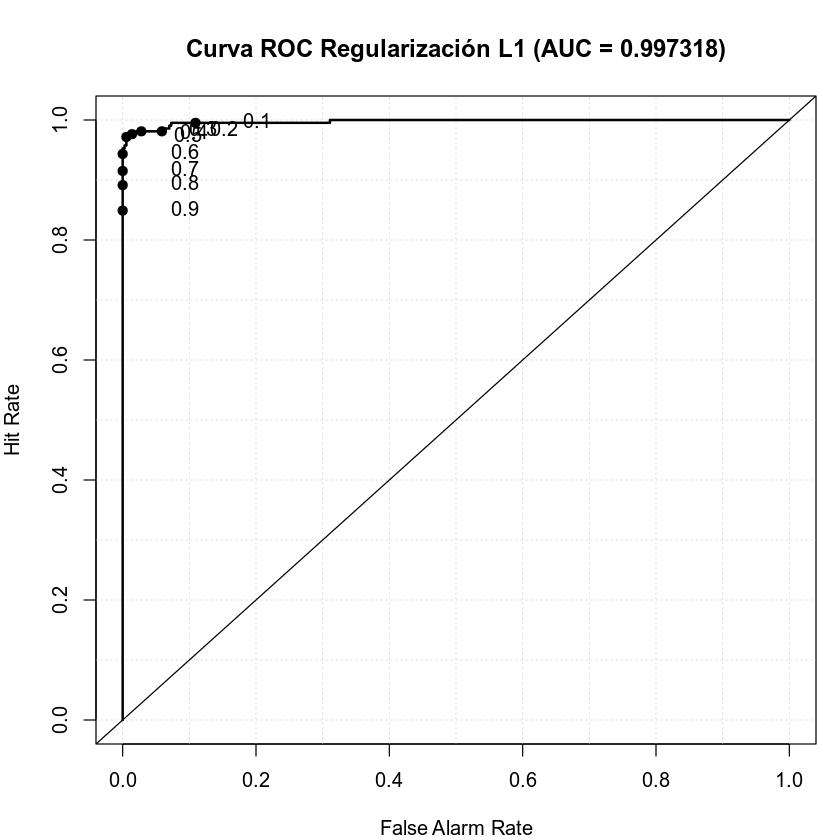

In [37]:
pred.l1 <- predict(cvfit, as.matrix(df[-1]), type = "response")
auc.l1 <- roc.area(df$diagnosis,pred.l1)$A
roc.plot(df$diagnosis, pred.l1, main=sprintf("Curva ROC Regularización L1 (AUC = %g)", auc.l1))

Observamos como, aún con solo 11 variables, el AUC es todavía bastante alto. Por ello se propone la siguiente tarea.

**TAREA 4:** Utilizar una validación cruzada tipo _hold out_ para comprobar si la capacidad de generalización del modelo ha mejorado con la regularización L1.

### Regularización L2 (ridge)
Si probásemos con la regularización L2 (parámetro `alpha = 0`), la norma-2 (norma euclídea) del vector de coeficientes se limita pero en este caso ningún coeficiente llega a anularse.

In [38]:
cvfit2 <- cv.glmnet(as.matrix(df[-1]), df$diagnosis, family = "binomial",alpha = 0)
ind.coef.no.nulos.l2 <- which(as.numeric(coef(cvfit2)) != 0)
cat(paste("Number of variables selected:", length(ind.coef.no.nulos.l2)))

Number of variables selected: 30

In [ ]:
# en r2 se aproximan a 0 pero no siempre llegan

Calculamos el AUC para el modelo regularizado con el penalty L2.

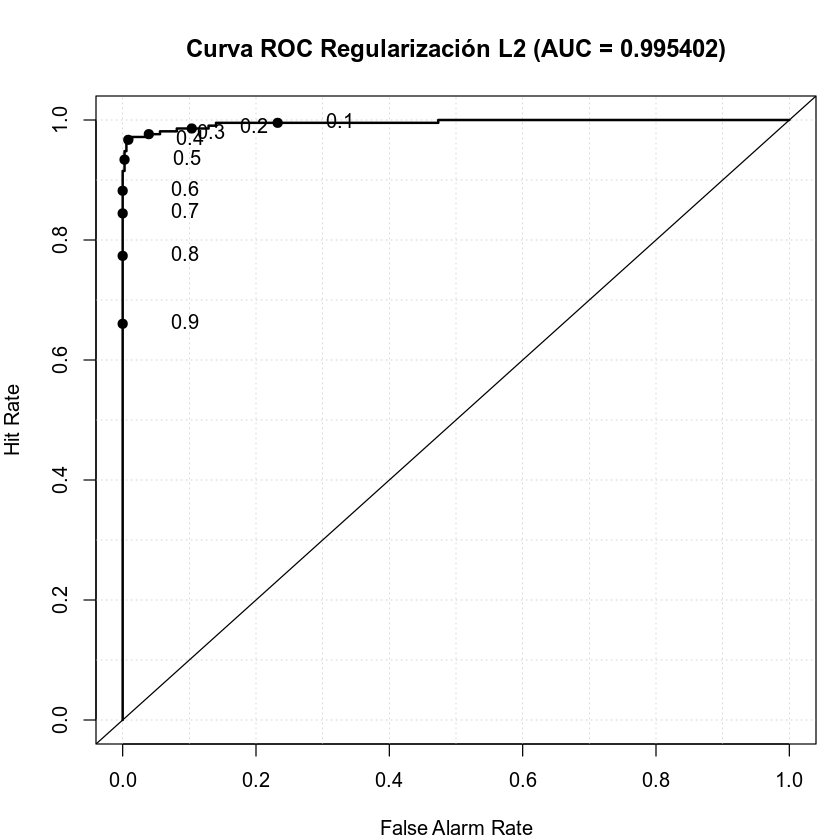

In [25]:
pred.l2 <- predict(cvfit2, as.matrix(df[-1]), type = "response")
auc.l2 <- roc.area(df$diagnosis, pred.l2)$A
roc.plot(df$diagnosis, pred.l2, main=sprintf("Curva ROC Regularización L2 (AUC = %g)", auc.l2))

**TAREA 5:** Comprobar la capacidad de generalización del modelo regularizado mediante _ridge regression_ y estudiar la evolución de los valores de los coeficientes en función del valor de `lambda`.

**TAREA 6:** Aplicar lo aprendido en esta práctica a otra de las bases de datos de ejemplo.